Compared to MNIST dataset, CIFAR10 images have 3 channels rather than 1. Also, we use a momentum optimizer with an initial learning rate of 0.01 (decaying by a factor of 0.95 every 390 epochs) and momentum of 0.9, just like in the [ICLR 2017 paper](https://arxiv.org/pdf/1611.03530.pdf). Also, batches sizes are 128 rather than 256.

The CIFAR10 images are also preprocessed via whitening, as described in the above paper.

In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"]="0"

In [2]:
%load_ext autoreload
%autoreload 2

import pickle
import time
import tensorflow as tf
import numpy as np

from analysis import *

%matplotlib inline

In [5]:
from get_cifar10 import get_cifar10_dataset
n_samps = 50000

# each value: Xtr, Ytr, Xtt, Ytt
data = {
    'true': get_cifar10_dataset(0, n_samps=n_samps),
    'rand': get_cifar10_dataset(100, n_samps=n_samps)
}
Xtr, Ytr, Xtt, Ytt = data['true']
Ytr_rand, Ytt_rand = data['rand'][1], data['rand'][3]
C2 = np.mean([np.sqrt(np.sum(np.square(i))) for i in Xtr])
gamma = 0.04*C2
eps_wrm = 1./(2*gamma)

### Inception

In [34]:
from spectral_adversarial_regularization.models import inception as model
eps_list = np.linspace(0, 0.0625, 6)*C2
archname = 'inception'

In [5]:
# Estimate eps for the other samples using the perturbation achieved for each test sample
save_dir = os.path.join('save_weights', 'cifar10', 'inception', 'inception_wrm_true')
arch = model.inception

Xtr_adv_wrm = ad.build_graph_and_gen_adv_examples(Xtr, arch, save_dir, beta=1, num_channels=3,
                                                  load_epoch=200, method=ad.wrm, eps=eps_wrm)
    
eps = np.sqrt(np.mean([np.sum(np.square(i)) for i in Xtr_adv_wrm-Xtr])) 
print(eps/C2)

# Note: the above eps/C2 is 0.0020451227, but we'll use 0.002
eps = 0.002*C2

INFO:tensorflow:Restoring parameters from save_weights/cifar10/inception/inception_wrm_true/checkpoints/epoch36
0.00204520484696


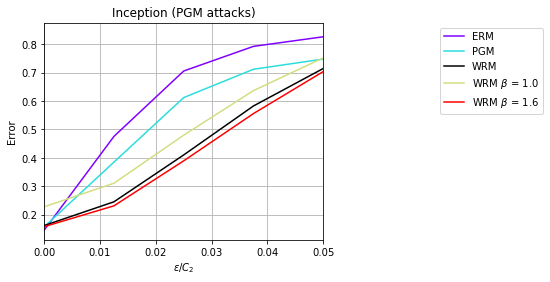

In [50]:
# Evaluate robustness of networks
labeltype = 'true'
arch = model.inception
methods = ['erm', 'pgm', 'wrm']

curves_file = 'save_weights/cifar10/inception/adv_attack_curves.pickle'

if os.path.isfile(curves_file):
    adv_results = pickle.load(file(curves_file, 'rb'))
else:
    adv_results = get_curves_for_arch(data, labeltype, arch, methods, eps_list, archname)
    pickle.dump(adv_results, file(curves_file, 'wb'))
    
# Generate adv attack curves for WRM SN
arch = model.inception_sn
for beta in [1.6, 1.5, 1.4, 0.9, 1.0, 1.2]:
    save_dir = 'save_weights/cifar10/inception/inception_wrm_true_beta%s/'%(beta)
    key = r'wrm $\beta$ = %s'%(beta)
    if key not in adv_results:
        acc, adv_accs = get_adv_acc_curve(Xtt, Ytt, save_dir,
                                          arch, eps_list, order=2, method=ad.pgm,
                                          beta=beta, load_epoch=200, num_channels=3)
        adv_results[key] = (acc, adv_accs, np.NaN)

plt.figure(figsize=(5, 4))
colors = cm.rainbow(np.linspace(0, 1, 4))
plt.plot(eps_list/C2, 1-adv_results['erm'][1], c=colors[0], label='ERM')
plt.plot(eps_list/C2, 1-adv_results['pgm'][1], c=colors[1], label='PGM')
plt.plot(eps_list/C2, 1-adv_results['wrm'][1], c='k', label='WRM')
plt.plot(eps_list/C2, 1-adv_results['wrm $\\beta$ = 1.0'][1], c=colors[2], label='WRM $\\beta$ = 1.0')
plt.plot(eps_list/C2, 1-adv_results['wrm $\\beta$ = 1.6'][1], c=colors[3], label='WRM $\\beta$ = 1.6')
plt.xlabel(r'$\epsilon/C_2$')
plt.xlim((0, 0.05))
plt.ylabel('Error')
# plt.ylim((0.1, 0.8))
plt.title('Inception (PGM attacks)')
plt.legend(bbox_to_anchor=(1.4, 1))
plt.grid(which="both")
plt.savefig('Figures/cifar10_inception_adv_attack_curves.pdf', format='pdf', dpi=500, bbox_inches='tight')
plt.show()

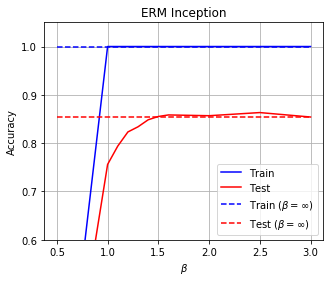

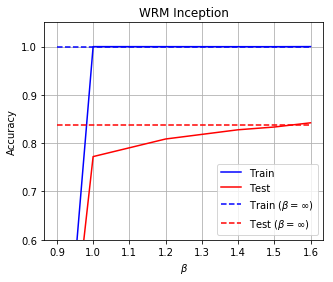

In [44]:
# Get final training and test accuracies
for method in ['erm', 'wrm']:
    train_test_accs_file = 'save_weights/cifar10/inception/%s_train_test_accs.pickle'%(method)
    results = get_train_test_accs(Xtr, Ytr, Xtt, Ytt, model.inception_sn, model.inception, adv=method,
                                  load_epoch=200, train_test_accs_file=train_test_accs_file,
                                  num_channels=3, maindir='save_weights/cifar10/inception/')
    plot_train_test_accs(results, logx=False, logy=False, ylim=(0.6, 1.05),
                         savename='Figures/cifar10_inception_train_test_accs_%s'%(method), 
                         title='%s %s'%(method.upper(), 'Inception'))

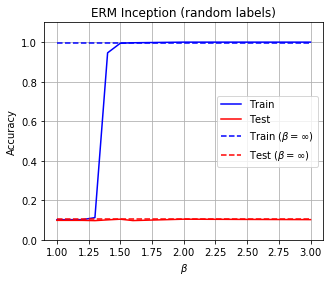

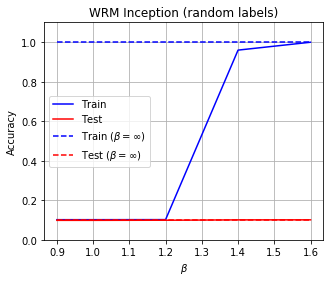

In [70]:
from spectral_adversarial_regularization.models import inception as model

# Get final training and test accuracies for networks trained on random labels
for method in ['erm', 'wrm']:
    train_test_accs_file = 'save_weights/cifar10/inception/%s_train_test_accs_randlabels.pickle'%(method)
    results = get_train_test_accs(Xtr, Ytr_rand, Xtt, Ytt_rand, model.inception_sn, model.inception,
                                  adv=method, load_epoch=200, train_test_accs_file=train_test_accs_file,
                                  num_channels=3, maindir='save_weights/cifar10/inception/', randmode=True)
    plot_train_test_accs(results, logy=False, ylim=(0, 1.1), logx=False,
                         savename='Figures/cifar10_inception_train_test_accs_randlabels_%s'%(method),
                         title='%s %s (random labels)'%(method.upper(), 'Inception'))

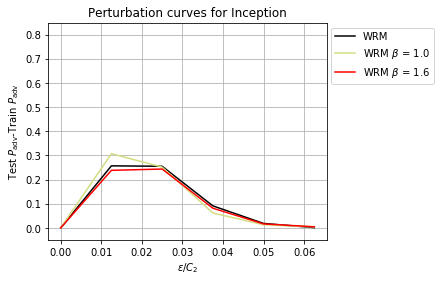

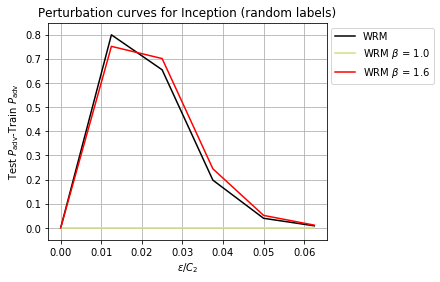

In [52]:
# Get perturbation curves
curves_file = 'save_weights/cifar10/inception/wrm_perturbation_curves.pickle'
adv_results = get_perturbation_curves(Xtr, Xtt, model.inception_sn, model.inception, 'wrm',
                                      eps_list, load_epoch=200, curves_file=curves_file, 
                                      maindir='save_weights/cifar10/inception/', num_channels=3,
                                      gpu_prop=0.2, skiprand=True, verbose=False)


plt.figure(figsize=(5, 4))
colors = cm.rainbow(np.linspace(0, 1, 4))
plt.plot(eps_list/C2,
         (1-adv_results['WRM True (test_refit)']) - \
         (1-adv_results['WRM True (train_refit)']),
         c='k', label='WRM')
plt.plot(eps_list/C2,
         (1-adv_results['WRM $\\beta$ = 1.0 True (test_refit)']) - \
         (1-adv_results['WRM $\\beta$ = 1.0 True (train_refit)']),
         c=colors[2], label='WRM $\\beta$ = 1.0')
plt.plot(eps_list/C2,
         (1-adv_results['WRM $\\beta$ = 1.6 True (test_refit)']) - \
         (1-adv_results['WRM $\\beta$ = 1.6 True (train_refit)']),
         c=colors[3], label='WRM $\\beta$ = 1.6')
plt.xlabel(r'$\epsilon/C_2$')
plt.ylabel(u'Test $P_{\mathregular{adv}}$-Train $P_{\mathregular{adv}}$')
plt.ylim((-0.05, 0.85))
plt.title('Perturbation curves for Inception')
plt.legend(bbox_to_anchor=(1.4, 1))
plt.grid(which="both")
plt.savefig('Figures/cifar10_inception_perturbation_curves_wrm_True.pdf', format='pdf', dpi=500, bbox_inches='tight')
plt.show()

plt.figure(figsize=(5, 4))
colors = cm.rainbow(np.linspace(0, 1, 4))
plt.plot(eps_list/C2,
         (1-adv_results['WRM Rand (test_refit)']) - \
         (1-adv_results['WRM Rand (train_refit)']),
         c='k', label='WRM')
plt.plot(eps_list/C2,
         (1-adv_results['WRM $\\beta$ = 1.0 Rand (test_refit)']) - \
         (1-adv_results['WRM $\\beta$ = 1.0 Rand (train_refit)']),
         c=colors[2], label='WRM $\\beta$ = 1.0')
plt.plot(eps_list/C2,
         (1-adv_results['WRM $\\beta$ = 1.6 Rand (test_refit)']) - \
         (1-adv_results['WRM $\\beta$ = 1.6 Rand (train_refit)']),
         c=colors[3], label='WRM $\\beta$ = 1.6')
plt.xlabel(r'$\epsilon/C_2$')
plt.ylabel(u'Test $P_{\mathregular{adv}}$-Train $P_{\mathregular{adv}}$')
plt.ylim((-0.05, 0.85))
plt.title('Perturbation curves for Inception (random labels)')
plt.legend(bbox_to_anchor=(1.4, 1))
plt.grid(which="both")
plt.savefig('Figures/cifar10_inception_perturbation_curves_wrm_Rand.pdf', format='pdf', dpi=500, bbox_inches='tight')
plt.show()

### Alexnet

In [73]:
from spectral_adversarial_regularization.models import alexnet as model
eps_list = np.linspace(0, 0.0625, 6)*C2
archname = 'alexnet'

In [6]:
# Estimate eps for the other samples using the perturbation achieved for each test sample
save_dir = os.path.join('save_weights', 'cifar10', 'alexnet', 'alexnet_wrm_true')
arch = model.alexnet

Xtr_adv_wrm = ad.build_graph_and_gen_adv_examples(Xtr, arch, save_dir, beta=1, num_channels=3,
                                                  load_epoch=200, method=ad.wrm, eps=eps_wrm)
    
eps = np.sqrt(np.mean([np.sum(np.square(i)) for i in Xtr_adv_wrm-Xtr])) 
print(eps/C2)

# Note: the above eps/C2 is 0.0016020516, but we'll use 0.0016
eps = 0.0016*C2

INFO:tensorflow:Restoring parameters from save_weights/cifar10/alexnet/alexnet_wrm_true/checkpoints/epoch25
0.0016020516226


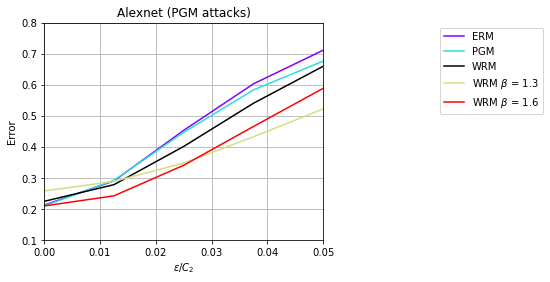

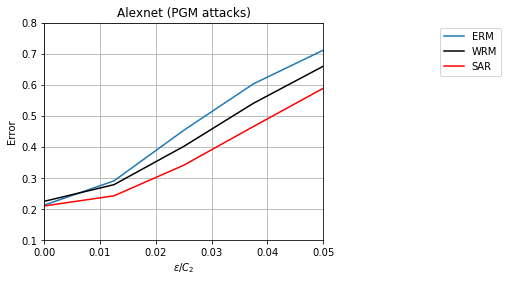

In [106]:
# Evaluate robustness of networks
labeltype = 'true'
arch = model.alexnet
methods = ['erm', 'fgm', 'pgm', 'wrm']

curves_file = 'save_weights/cifar10/alexnet/adv_attack_curves.pickle'

if os.path.isfile(curves_file):
    adv_results = pickle.load(file(curves_file, 'rb'))
else:
    adv_results = get_curves_for_arch(data, labeltype, arch, methods, eps_list, archname)
    pickle.dump(adv_results, file(curves_file, 'wb'))
    
# Generate adv attack curves for WRM SN
arch = model.alexnet_sn
for beta in [1.6, 1.3, 2.0, 4.0]:
    save_dir = 'save_weights/cifar10/alexnet/alexnet_wrm_true_beta%s/'%(beta)
    key = r'wrm $\beta$ = %s'%(beta)
    if key not in adv_results:
        acc, adv_accs = get_adv_acc_curve(Xtt, Ytt, save_dir,
                                          arch, eps_list, order=2, method=ad.pgm,
                                          beta=beta, load_epoch=200, num_channels=3)
        adv_results[key] = (acc, adv_accs, np.NaN)
        
# Make plots
plt.figure(figsize=(5, 4))
colors = cm.rainbow(np.linspace(0, 1, 4))
plt.plot(eps_list/C2, 1-adv_results['erm'][1], c=colors[0], label='ERM')
plt.plot(eps_list/C2, 1-adv_results['pgm'][1], c=colors[1], label='PGM')
plt.plot(eps_list/C2, 1-adv_results['wrm'][1], c='k', label='WRM')
plt.plot(eps_list/C2, 1-adv_results['wrm $\\beta$ = 1.3'][1], c=colors[2], label='WRM $\\beta$ = 1.3')
plt.plot(eps_list/C2, 1-adv_results['wrm $\\beta$ = 1.6'][1], c=colors[3], label='WRM $\\beta$ = 1.6')
plt.xlabel(r'$\epsilon/C_2$')
plt.xlim((0, 0.05))
plt.ylabel('Error')
plt.ylim((0.1, 0.8))
plt.title('Alexnet (PGM attacks)')
plt.legend(bbox_to_anchor=(1.4, 1))
plt.grid(which="both")
plt.savefig('Figures/cifar10_alexnet_adv_attack_curves.pdf', format='pdf', dpi=500, bbox_inches='tight')
plt.show()

plt.figure(figsize=(5, 4))
colors = cm.rainbow(np.linspace(0, 1, 4))
plt.plot(eps_list/C2, 1-adv_results['erm'][1], label='ERM')
plt.plot(eps_list/C2, 1-adv_results['wrm'][1], c='k', label='WRM')
plt.plot(eps_list/C2, 1-adv_results['wrm $\\beta$ = 1.6'][1], c='r', label='SAR')
plt.xlabel(r'$\epsilon/C_2$')
plt.xlim((0, 0.05))
plt.ylabel('Error')
plt.ylim((0.1, 0.8))
plt.title('Alexnet (PGM attacks)')
plt.legend(bbox_to_anchor=(1.4, 1))
plt.grid(which="both")
plt.savefig('Figures/cifar10_alexnet_adv_attack_curves_lesscurves.pdf', format='pdf', dpi=500, bbox_inches='tight')
plt.show()

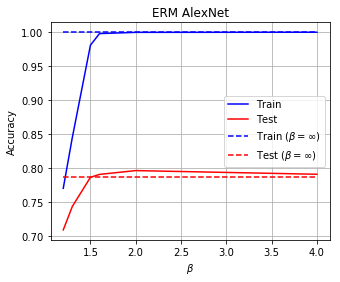

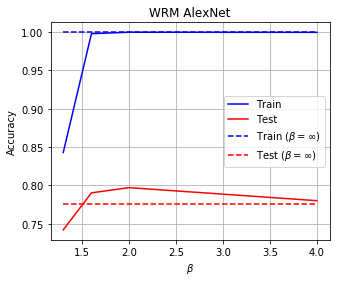

In [32]:
# Get final training and test accuracies
for method in ['erm', 'wrm']:
    train_test_accs_file = 'save_weights/cifar10/alexnet/%s_train_test_accs.pickle'%(method)
    results = get_train_test_accs(Xtr, Ytr, Xtt, Ytt, model.alexnet_sn, model.alexnet, adv=method,
                                  load_epoch=200, train_test_accs_file=train_test_accs_file,
                                  num_channels=3, maindir='save_weights/cifar10/alexnet/')
    for i in results.keys():
        if '1.0' in i or '1.1' in i or '0.5' in i:
            results.pop(i)
    plot_train_test_accs(results, logx=False, logy=False, ylim=None,
                         savename='Figures/cifar10_alexnet_train_test_accs_%s'%(method), 
                         title='%s %s'%(method.upper(), 'AlexNet'))

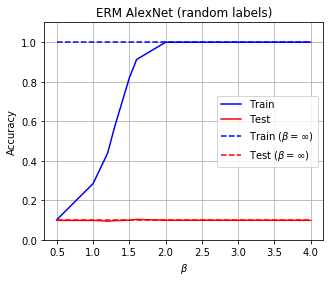

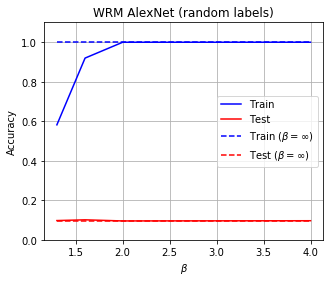

In [33]:
# Get final training and test accuracies for networks trained on random labels
for method in ['erm', 'wrm']:
    train_test_accs_file = 'save_weights/cifar10/alexnet/%s_train_test_accs_randlabels.pickle'%(method)
    results = get_train_test_accs(Xtr, Ytr_rand, Xtt, Ytt_rand, model.alexnet_sn, model.alexnet,
                                  adv=method, load_epoch=200, train_test_accs_file=train_test_accs_file,
                                  num_channels=3, maindir='save_weights/cifar10/alexnet/', randmode=True)
    plot_train_test_accs(results, logx=False, logy=False, ylim=(0, 1.1),
                         savename='Figures/cifar10_alexnet_train_test_accs_randlabels_%s'%(method), 
                         title='%s %s (random labels)'%(method.upper(), 'AlexNet'))

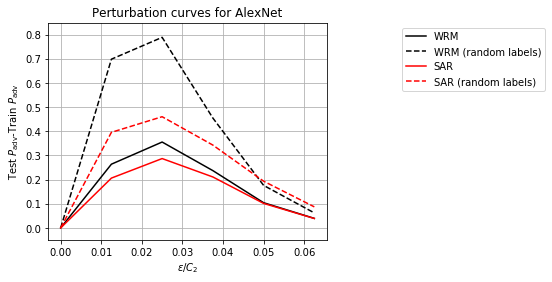

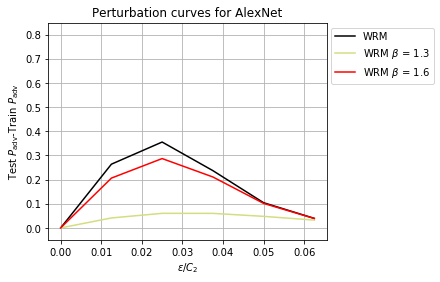

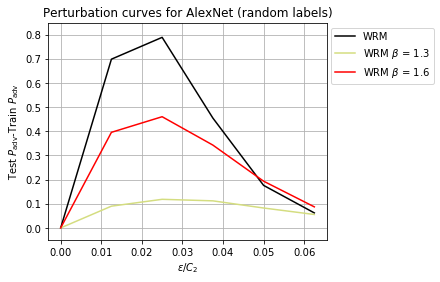

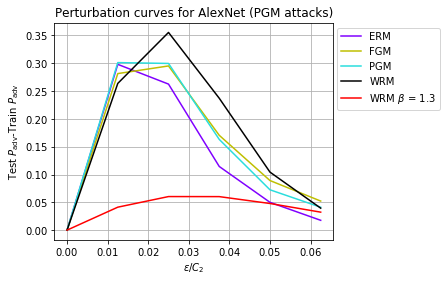

In [115]:
# Get perturbation curves
curves_file = 'save_weights/cifar10/alexnet/wrm_perturbation_curves.pickle'
adv_results = get_perturbation_curves(Xtr, Xtt, model.alexnet_sn, model.alexnet, 'wrm',
                                      eps_list, load_epoch=200, curves_file=curves_file, 
                                      maindir='save_weights/cifar10/alexnet/', num_channels=3,
                                      gpu_prop=0.2, skiprand=False, verbose=False)

plt.figure(figsize=(5, 4))
colors = cm.rainbow(np.linspace(0, 1, 4))
plt.plot(eps_list/C2,
         (1-adv_results['WRM True (test_refit)']) - \
         (1-adv_results['WRM True (train_refit)']),
         c = 'k', label='WRM')
plt.plot(eps_list/C2,
         (1-adv_results['WRM Rand (test_refit)']) - \
         (1-adv_results['WRM Rand (train_refit)']), '--',
         c = 'k', label='WRM (random labels)')
plt.plot(eps_list/C2,
         (1-adv_results['WRM $\\beta$ = 1.6 True (test_refit)']) - \
         (1-adv_results['WRM $\\beta$ = 1.6 True (train_refit)']),
         c = 'r', label='SAR')
plt.plot(eps_list/C2,
         (1-adv_results['WRM $\\beta$ = 1.6 Rand (test_refit)']) - \
         (1-adv_results['WRM $\\beta$ = 1.6 Rand (train_refit)']), '--',
         c = 'r', label='SAR (random labels)')
plt.xlabel(r'$\epsilon/C_2$')
plt.ylabel(u'Test $P_{\mathregular{adv}}$-Train $P_{\mathregular{adv}}$')
plt.ylim((-0.05, 0.85))
plt.title('Perturbation curves for AlexNet')
plt.legend(bbox_to_anchor=(1.8, 1))
plt.grid(which="both")
plt.savefig('Figures/cifar10_alexnet_perturbation_curves_wrm_lesscurves.pdf', format='pdf', dpi=500, bbox_inches='tight')
plt.show()

plt.figure(figsize=(5, 4))
colors = cm.rainbow(np.linspace(0, 1, 4))
plt.plot(eps_list/C2,
         (1-adv_results['WRM True (test_refit)']) - \
         (1-adv_results['WRM True (train_refit)']),
         c='k', label='WRM')
plt.plot(eps_list/C2,
         (1-adv_results['WRM $\\beta$ = 1.3 True (test_refit)']) - \
         (1-adv_results['WRM $\\beta$ = 1.3 True (train_refit)']),
         c=colors[2], label='WRM $\\beta$ = 1.3')
plt.plot(eps_list/C2,
         (1-adv_results['WRM $\\beta$ = 1.6 True (test_refit)']) - \
         (1-adv_results['WRM $\\beta$ = 1.6 True (train_refit)']),
         c=colors[3], label='WRM $\\beta$ = 1.6')
plt.xlabel(r'$\epsilon/C_2$')
plt.ylabel(u'Test $P_{\mathregular{adv}}$-Train $P_{\mathregular{adv}}$')
plt.ylim((-0.05, 0.85))
plt.title('Perturbation curves for AlexNet')
plt.legend(bbox_to_anchor=(1.4, 1))
plt.grid(which="both")
plt.savefig('Figures/cifar10_alexnet_perturbation_curves_wrm_True.pdf', format='pdf', dpi=500, bbox_inches='tight')
plt.show()

plt.figure(figsize=(5, 4))
colors = cm.rainbow(np.linspace(0, 1, 4))
plt.plot(eps_list/C2,
         (1-adv_results['WRM Rand (test_refit)']) - \
         (1-adv_results['WRM Rand (train_refit)']),
         c='k', label='WRM')
plt.plot(eps_list/C2,
         (1-adv_results['WRM $\\beta$ = 1.3 Rand (test_refit)']) - \
         (1-adv_results['WRM $\\beta$ = 1.3 Rand (train_refit)']),
         c=colors[2], label='WRM $\\beta$ = 1.3')
plt.plot(eps_list/C2,
         (1-adv_results['WRM $\\beta$ = 1.6 Rand (test_refit)']) - \
         (1-adv_results['WRM $\\beta$ = 1.6 Rand (train_refit)']),
         c=colors[3], label='WRM $\\beta$ = 1.6')
plt.xlabel(r'$\epsilon/C_2$')
plt.ylabel(u'Test $P_{\mathregular{adv}}$-Train $P_{\mathregular{adv}}$')
plt.ylim((-0.05, 0.85))
plt.title('Perturbation curves for AlexNet (random labels)')
plt.legend(bbox_to_anchor=(1.4, 1))
plt.grid(which="both")
plt.savefig('Figures/cifar10_alexnet_perturbation_curves_wrm_Rand.pdf', format='pdf', dpi=500, bbox_inches='tight')
plt.show()

plt.figure(figsize=(5, 4))
colors = cm.rainbow(np.linspace(0, 1, 4))
plt.plot(eps_list/C2,
         (1-adv_results['ERM True (test_refit)']) - \
         (1-adv_results['ERM True (train_refit)']),
         c=colors[0], label='ERM')
plt.plot(eps_list/C2,
         (1-adv_results['FGM True (test_refit)']) - \
         (1-adv_results['FGM True (train_refit)']),
         c='y', label='FGM')
plt.plot(eps_list/C2,
         (1-adv_results['PGM True (test_refit)']) - \
         (1-adv_results['PGM True (train_refit)']),
         c=colors[1], label='PGM')
plt.plot(eps_list/C2,
         (1-adv_results['WRM True (test_refit)']) - \
         (1-adv_results['WRM True (train_refit)']),
         c='k', label='WRM')
plt.plot(eps_list/C2,
         (1-adv_results['WRM $\\beta$ = 1.3 True (test_refit)']) - \
         (1-adv_results['WRM $\\beta$ = 1.3 True (train_refit)']),
         c='r', label='WRM $\\beta$ = 1.3')
plt.xlabel(r'$\epsilon/C_2$')
plt.ylabel(u'Test $P_{\mathregular{adv}}$-Train $P_{\mathregular{adv}}$')
plt.title('Perturbation curves for AlexNet (PGM attacks)')
plt.legend(bbox_to_anchor=(1.4, 1))
plt.grid(which="both")
plt.savefig('Figures/cifar10_alexnet_perturbation_curves_wrm_othermethods.pdf', format='pdf', dpi=500, bbox_inches='tight')
plt.show()

In [108]:
# Look at perturbed images
beta = 1.6
eps = 0.025*C2
n = 1000

cifar10_label_dict = {
    0: 'airplane',
    1: 'automobile',
    2: 'bird', 
    3: 'cat',
    4: 'deer',
    5: 'dog',
    6: 'frog',
    7: 'horse',
    8: 'ship',
    9: 'truck'
}

# from scipy.stats import itemfreq
# itemfreq(map(lambda x: cifar10_label_dict[x], Y_adv_sn))

save_dir = 'save_weights/cifar10/alexnet/alexnet_wrm_true/'
save_dir_sn = 'save_weights/cifar10/alexnet/alexnet_wrm_true_beta%s/'%(beta)

import tflearn
datasets = list(tflearn.datasets.cifar10.load_data())
Xtr_, Ytr_, Xtt_, Ytt_ =  datasets[0][0][:n], datasets[0][1][:n], datasets[1][0][:n], datasets[1][1][:n]

INFO:tensorflow:Restoring parameters from save_weights/cifar10/alexnet/alexnet_wrm_true/checkpoints/epoch25
INFO:tensorflow:Restoring parameters from save_weights/cifar10/alexnet/alexnet_wrm_true/checkpoints/epoch25
Acc on adv examples: 0.8520
INFO:tensorflow:Restoring parameters from save_weights/cifar10/alexnet/alexnet_wrm_true_beta1.6/checkpoints/epoch200
INFO:tensorflow:Restoring parameters from save_weights/cifar10/alexnet/alexnet_wrm_true_beta1.6/checkpoints/epoch200
Acc on adv examples: 0.8860
Num test samples where sn with beta = 1.6 does better: 127
Num test samples where sn with beta = infinity does better: 93


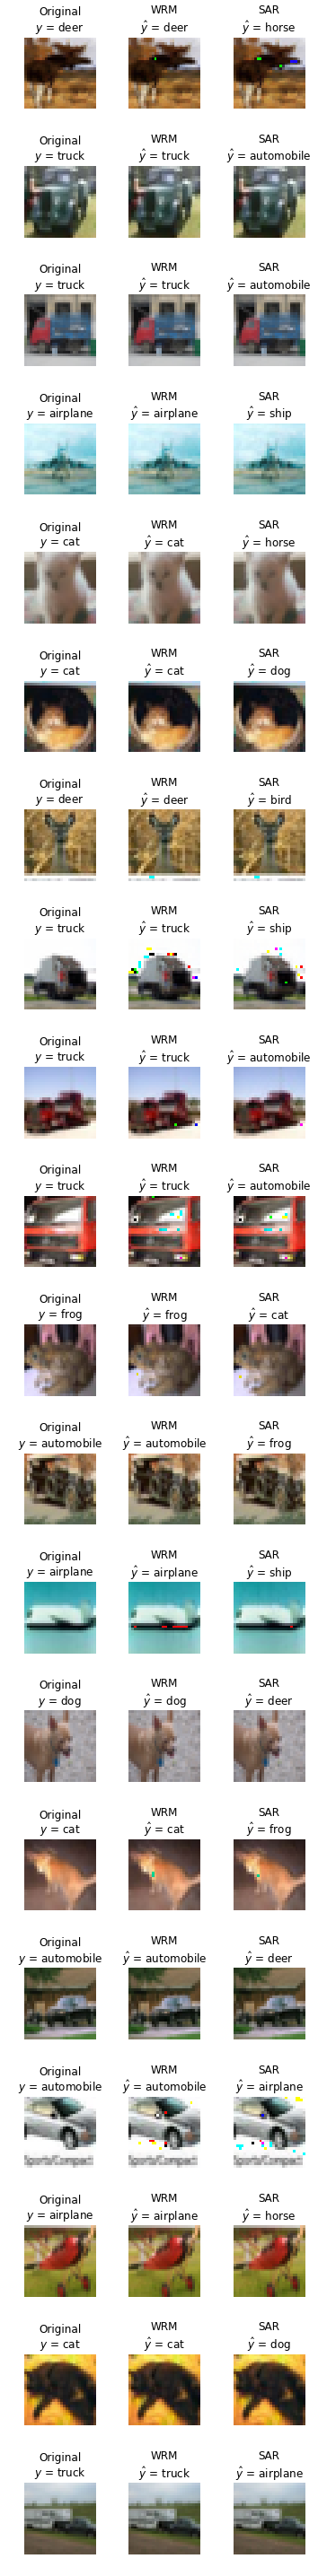

In [137]:
# Training samples
Xtr_adv, Ytr_adv, Xtr_adv_sn, Ytr_adv_sn = perturb_images_wrm_v_wrmsn(Xtr_, Ytr_, eps, beta,
                                                                      model.alexnet, model.alexnet_sn,
                                                                      save_dir, save_dir_sn)
inds_of_interest = np.where((Ytr_ != Ytr_adv_sn) & (Ytr_ == Ytr_adv))[0]
Xtr_crop = np.array([i[2:30, 2:30, :] for i in Xtr_])
show_perturbed_images(Xtr_crop, Xtr_adv, Xtr_adv_sn, Ytr_, Ytr_adv, Ytr_adv_sn, cifar10_label_dict, eps, beta,
                      n=20, seed=1, savename='Figures/cifar10_alexnet_pgm_attacks_sn_v_nosn_train_beta%s.pdf'%(beta),
                      inds_of_interest=inds_of_interest)

INFO:tensorflow:Restoring parameters from save_weights/cifar10/alexnet/alexnet_wrm_true/checkpoints/epoch25
INFO:tensorflow:Restoring parameters from save_weights/cifar10/alexnet/alexnet_wrm_true/checkpoints/epoch25
Acc on adv examples: 0.5990
INFO:tensorflow:Restoring parameters from save_weights/cifar10/alexnet/alexnet_wrm_true_beta1.6/checkpoints/epoch200
INFO:tensorflow:Restoring parameters from save_weights/cifar10/alexnet/alexnet_wrm_true_beta1.6/checkpoints/epoch200
Acc on adv examples: 0.6800
Num test samples where sn with beta = 1.6 does better: 204
Num test samples where sn with beta = infinity does better: 123


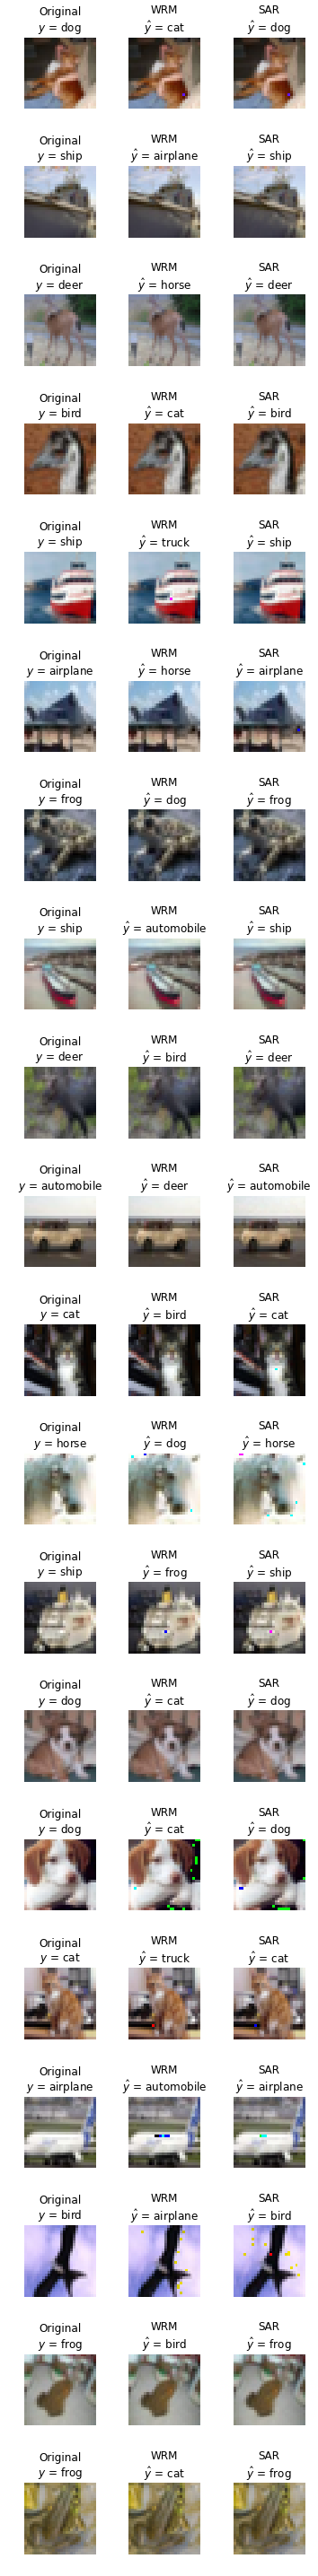

In [138]:
# Test samples
Xtt_adv, Ytt_adv, Xtt_adv_sn, Ytt_adv_sn = perturb_images_wrm_v_wrmsn(Xtt_, Ytt_, eps, beta,
                                                                      model.alexnet, model.alexnet_sn,
                                                                      save_dir, save_dir_sn)
inds_of_interest = np.where((Ytt_ != Ytt_adv) & (Ytt_ == Ytt_adv_sn))[0]
Xtt_crop = np.array([i[2:30, 2:30, :] for i in Xtt_])
show_perturbed_images(Xtt_crop, Xtt_adv, Xtt_adv_sn, Ytt_, Ytt_adv, Ytt_adv_sn, cifar10_label_dict, eps, beta,
                      n=20, seed=1, savename='Figures/cifar10_alexnet_pgm_attacks_sn_v_nosn_test_beta%s.pdf'%(beta),
                      inds_of_interest=inds_of_interest)